<img src="images/deep_ga.png" align=right width=50%></img>
# Deep Neuroevolution
Author: Jin Yeom (jinyeom@utexas.edu)

## Contents
- [Configuration](#Configuration)
- [Environment](#Environment)
- [Genotype](#Genotype)
- [Phenotype](#Phenotype)
- [Genetic Algorithm (GA)](#Genetic-Algorithm-%28GA%29)

In [1]:
import random
import pickle
from copy import deepcopy

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
import gym
from gym import ObservationWrapper
from gym.spaces.box import Box
from baselines.common import atari_wrappers
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import functional as T
from torchsummary import summary
from deap import creator, base, tools
from IPython import display

In [2]:
%matplotlib inline

## Configuration

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE =", DEVICE)

DEVICE = cuda


In [4]:
# standard deviation for adding noise each mutation
SIGMA = 0.005
# environment name
ENV_NAME = "PongNoFrameskip-v4"
# environment seed
ENV_SEED = 42
# observation screen size
SCREEN_SIZE = 84
# number of channels (stacked frames)
N_CHAN = 4
# maximum iterations during evaluation
MAX_ITER = 5000
# number of generations during evolution
N_GEN = 1000
# population size
POP_SIZE = 1000
# number of selected individuals each generation
N_SEL = 200

## Environment

In [83]:
class TorchWrapper(ObservationWrapper):
    r"""ObservationWrapper that outputs observation with the shape of (channels, height, width).
    NOTE: adopted from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr.
    """
    def __init__(self, env=None):
        super(TorchWrapper, self).__init__(env)
        obs_shape = self.observation_space.shape
        self.observation_space = Box(self.observation_space.low[0, 0, 0],
                                     self.observation_space.high[0, 0, 0],
                                     [obs_shape[2], obs_shape[1], obs_shape[0]],
                                     dtype=self.observation_space.dtype)

    def observation(self, x):
        x = x.transpose(2, 0, 1)
        return torch.tensor(x, dtype=torch.float, device=DEVICE)

In [84]:
def make_atari(env_id):
    env = atari_wrappers.make_atari(env_id)
    env = atari_wrappers.wrap_deepmind(env)
    env = TorchWrapper(env)
    env.seed(ENV_SEED)
    return env

In [85]:
def render(state, obs_mean):
    display.clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.axis("off")
    ax1.set_title("State")
    ax1.imshow(state)
    ax2.axis("off")
    ax2.set_title("Observation (mean)")
    ax2.imshow(obs_mean)
    plt.pause(0.001)

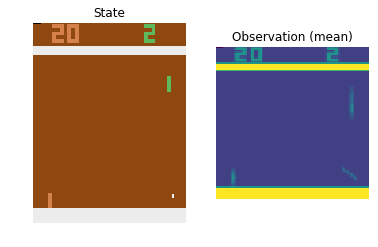

In [86]:
env = make_atari(ENV_NAME)
stacked_frames = [env.reset() for _ in range(4)]

t = done = 0
while not done:
    if t % 10 == 0:
        state = env.render("rgb_array")
        obs_mean = sum(stacked_frames).squeeze()
        render(state, obs_mean)
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    stacked_frames.pop(0)
    stacked_frames.append(obs)
    t += 1

## Genotype

In [5]:
def rand_seed():
    return random.randint(0, 2**31-1)

In [6]:
def mutate(ind):
    ind.append(rand_seed())
    return deepcopy(ind)

In [7]:
def decode(genotype, model, sigma):
    # NOTE: making a copy of the template model only makes sense in parallel settings
    # model = deepcopy(model)
    init_seed, mut_seeds = genotype[0], genotype[1:]
    # initialize the model using initialization seed
    torch.manual_seed(init_seed)
    def init_weights(m):
        if type(m) in {nn.Conv2d, nn.Linear}:
            torch.nn.init.xavier_normal_(m.weight)
    model.apply(init_weights)
    # mutate the model using mutation seeds
    for seed in mut_seeds:
        torch.manual_seed(seed)
        for param in model.parameters():
            param.data.add_(torch.randn_like(param) * sigma)
    return model

Ooh, looks like we're going to have to implement the phenotype before testing `decode`.

## Phenotype

In [8]:
class NatureDQN(nn.Module):
    def __init__(self, in_channels=4, act_dim=18):
        super(NatureDQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, act_dim)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc4(x))
        return F.softmax(self.fc5(x), dim=-1)

Now, let's take a look at the network. Remember, `TMPL_MODEL` below will be used to decode each individual genotype during evolution.

In [9]:
TMPL_MODEL = NatureDQN().to(DEVICE)
summary(TMPL_MODEL, (4, SCREEN_SIZE, SCREEN_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 20, 20]           8,224
            Conv2d-2             [-1, 64, 9, 9]          32,832
            Conv2d-3             [-1, 64, 7, 7]          36,928
            Linear-4                  [-1, 512]       1,606,144
            Linear-5                   [-1, 18]           9,234
Total params: 1,693,362
Trainable params: 1,693,362
Non-trainable params: 0
----------------------------------------------------------------


Now that we have the genotype and the phenotype both ready, we can write an `evaluate` method.

In [79]:
def evaluate(ind):
    policy = decode(ind, TMPL_MODEL, SIGMA)
    policy.eval()
    
    env = make_atari(ENV_NAME)
    stacked_frames = [env.reset() for _ in range(4)]
    t = done = fitness = 0
    while not done and t < MAX_ITER:
        obs = torch.cat(stacked_frames, dim=0).unsqueeze(0)
        act_probs = policy(obs)
        action = torch.argmax(act_probs)
        next_frame, reward, done, _ = env.step(action)
        stacked_frames.pop(0) # remove the first frame
        stacked_frames.append(next_frame) # add the next frame
        fitness += reward
        t += 1
    return fitness,

## Genetic Algorithm (GA)

In [61]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

/home/jin/anaconda3/envs/research/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/jin/anaconda3/envs/research/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [80]:
toolbox = base.Toolbox()
toolbox.register("individual", tools.initRepeat, creator.Individual, rand_seed, n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mutate", mutate)
toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selBest)

In [81]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("mean", np.mean)
stats.register("std", np.std)
stats.register("max", np.max)

elite = tools.HallOfFame(1)
logbook = tools.Logbook()

In [82]:
population = toolbox.population(POP_SIZE)
for gen in tqdm(range(N_GEN), desc="gen."):
    # evaluate the population
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
        
    # update hall of fame and record evaluations
    hof.update(population)
    record = stats.compile(population)
    logbook.record(gen=gen, evals=len(invalid_ind), **record)
    
    # selection and mutation to update population
    elite = deepcopy(hof[0]) # updated elite after evaluation
    selected = toolbox.select(population, k=N_SEL)
    offsprings = [toolbox.mutate(random.choice(selected)) for _ in range(POP_SIZE - 1)]
    population = offsprings + [elite]

IndexError: index 14 is out of bounds for axis 0 with size 6